# Loading SpikeSorting Data

In [ ]:
# Turn off logging, this is a hidden cell on docs page
import logging
logger = logging.getLogger('ibllib')
logger.setLevel(logging.CRITICAL)

Spikesorted output of electrophysiology data.

## Relevant Alf objects
* channels
* clusters
* spikes

## Loading

In [1]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas

one = ONE()
ba = AllenAtlas()
pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd' 

sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

/Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 141M/141M [00:04<00:00, 33.3MB/s] 
/Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 70.3M/70.3M [00:02<00:00, 28.2MB/s]
/Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 141M/141M [00:05<00:00, 27.2MB/s] 
/Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 141M/141M [00:06<00:00, 21.6MB/s] 


Downloading: /Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/clusters.metrics.feae3962-835c-43cf-8f97-539d68b8906d.pqt Bytes: 107637


  0%|          | 0/0.10265064239501953 [00:00<?, ?it/s]

Downloading: /Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/clusters.channels.b89869a6-541b-4b65-961d-a8f523eec728.npy Bytes: 7440Downloading: /Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/clusters.depths.3694107b-230d-43d8-aeea-56b4aaf5a384.npy Bytes: 3784




  0%|          | 0/0.00360870361328125 [00:00<?, ?it/s]

100%|██████████| 0.00360870361328125/0.00360870361328125 [00:00<00:00,  3.05s/it]
100%|██████████| 0.0070953369140625/0.0070953369140625 [00:00<00:00,  1.13it/s]


Downloading: /Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/clusters.uuids.926b88ce-c08e-410d-ba84-c442472d1fed.csv Bytes: 33823



  0%|          | 0/0.032256126403808594 [00:00<?, ?it/s]
100%|██████████| 0.032256126403808594/0.032256126403808594 [00:00<00:00,  4.73s/it]
100%|██████████| 0.10265064239501953/0.10265064239501953 [00:00<00:00,  3.77s/it]
/Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 18.8kB/s]
/Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 13.0kB/s]
/Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 13.1kB/s]
/Users/gaelle/Downloads/FlatIron/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 8.75kB/s]


Alternatively, one can instantiate the spike sorting loader using the session unique identifier eid and the probe name pname:

In [2]:
eid, pname = one.pid2eid(pid)
sl = SpikeSortingLoader(eid=eid, pname=pname, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

## More details
* [Description of spikesorting datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.5houj8bng5o)
* Available spikesorting algorithms
    * [pykilosort](https://github.com/int-brain-lab/pykilosort#readme) (All data)
    * [Kilosort 2.5](https://github.com/MouseLand/Kilosort/releases/tag/v2.5) (Most data collected before August 2021)

## Important information
1. Data sorted with pykilosort is loaded by default. If the pykilosort spikesorting data is not available, the matlab kilosort 2.5 version will be loaded. See [Example 1](#Example-1:-Loading-different-spikesorting-versions) for more information.  
2. The channel locations in the brain can come from several sources. it will load the most advanced version of the histology available, regardless of the spike sorting version loaded.  
The steps, from most to least advanced, are:
    * **alf**: the final version of channel locations, same as resolved with the difference that data has been written out to files
    * **resolved**: channel location alignments have been agreed upon
    * **aligned**: channel locations have been aligned, but review or other alignments are pending, potentially not accurate
    * **traced**: the histology track has been recovered from microscopy, however the depths may not match, inacurate data
3. The attributes `mlapdv`, `atlas_ids` and `acronyms` in the `clusters` and `channels` objects are only available for probe insertions where `sl.histology` is equal to **traced**, **aligned**, **resolved** or **alf**.
4. The cluster and channel locations in the brain are only considered final for probe insertions with `sl.histology='resolved'`or `sl.histology='alf'`.

## Useful modules
* [brainbox.io.one.SpikeSortingLoader](https://int-brain-lab.github.io/iblenv/_autosummary/brainbox.io.one.html#brainbox.io.one.SpikeSortingLoader)
* [brainbox.ephys_plots](https://int-brain-lab.github.io/iblenv/_autosummary/brainbox.ephys_plots.html)
* [brainbox.population.decode.get_spike_counts_in_bins](https://int-brain-lab.github.io/iblenv/_autosummary/brainbox.population.decode.html#brainbox.population.decode.get_spike_counts_in_bins)
* [brainbox.processing](https://int-brain-lab.github.io/iblenv/_autosummary/brainbox.processing.html#brainbox.processing)
* [brainbox.metrics.single_units](https://int-brain-lab.github.io/iblenv/_autosummary/brainbox.metrics.single_units.html#module-brainbox.metrics.single_units)

## Exploring spikesorting data

### Example 1: Loading different spikesorting versions

In [ ]:
# By default, if available, the data spikesorted with pykilosort is loaded. 
# To find the spikesorting version that is loaded we can use
sl.collection

# To see all available spikesorted data for this probe insertion we can list the collections. 
# N.B. ks2.5 matlab spikesorted data is stored in the alf/probe00 folder
sl.collections

# The following can be used to load a specific version of spikesorting

# pykilosort version
spikes, clusters, channels = sl.load_spike_sorting(spike_sorter='pykilosort')

# ks2.5 matlab version
spikes, clusters, channels = sl.load_spike_sorting(spike_sorter='')

### Example 2: Loading additional data

In [ ]:
# The default spikes and cluster attributes loaded are:
# spikes - amps, clusters, depths, times
# cluster - channels, depths, metrics

#Other attributes can additionally be loaded in the following way
spikes, clusters, channels = sl.load_spike_sorting(dataset_types=['clusters.amps', 'spikes.samples'])
clusters = sl.merge_clusters(spikes, clusters, channels)

### Example 3: Compute firing rate across session

In [ ]:
from brainbox.ephys_plots import image_fr_plot
from brainbox.processing import bincount2D
import numpy as np

time_bin = 0.05 # time bin in seconds
depth_bin = 10 # depth bin in um

# Remove any nan values
kp_idx = np.bitwise_and(~np.isnan(spikes['times']), ~np.isnan(spikes['depths']))

fr, time, depth = bincount2D(spikes['times'][kp_idx], spikes['depths'][kp_idx], time_bin, depth_bin)

### Example 4: Find clusters labelled as good

In [ ]:
good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1]

### Example 5: Plot a raster for all units

(<Figure size 1152x648 with 1 Axes>,
 <AxesSubplot:title={'center':'da8dfec1-d265-44e8-84ce-6ae9c109b8bd \n2020-09-21_1_SWC_043_probe00 \n17_575_242 spikes, 914 clusters'}, xlabel='time (secs)', ylabel='depth (um)'>)

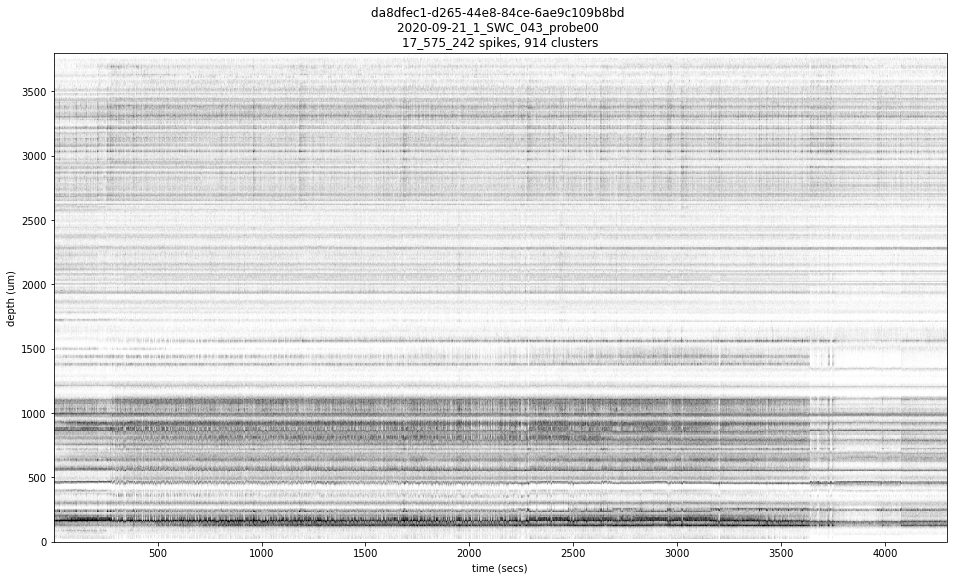

In [2]:
sl.raster(spikes)

## Other relevant examples
* COMING SOON